# K Means Clustering

K means clustering is an unsupervised learning technique. It takes unlabeled data and assigns a label to it from k possible labels. The labeling is accomplished by finding k points (centroids) within the dimensions of the dataset and assigning that label to the the datapoints that fall closest to the centroid.

There are a variety of ways to take the measurements for the clusters, but one common one, and the one this notebook will use is the Euclidean distance.

Euclidean distance is the square root of the sum of the square of the difference of each element in two vectors. More simply, its the straight line distance between points:

$D = \sqrt{(a_1 - b_1)^2+(a_2 - b_2)^2+\dots+(a_n - b_n)^2} = \sqrt{\sum_{i=1}^n (a_i - b_i)^2}$

Where:
- $D$ is the Euclidean distance
- $a$ and $b$ are vectors of equal length

### The algorithm:
1. Choose a value for k
2. Within the data space create k centroids
3. Assign each datapoint to the nearest centroid
4. Move each centroid to the center of the cluster of data points it represents
5. Repeat until convergence

## Explanation

We'll pick a value for $k$, note that this is going to be based on factors specific to the problem at hand and you may need to try several different values for $k$ until one works. This algorithm does not necessarily have a correct answer, it assists us in labeling data based on similarities between observations.

Randomly initialize $k$ centroids. Each centroid is a point in the data space, so if all of the data falls within certain ranges it wouldn't make sense to create an initial centroid outside of this range.

Iterate through each datapoint and calculate the Euclidean distance between that point and each centroid. The datapoint will be assigned to the cluster with the closest centroid.

After iterating through all datapoints take the mean of each cluster. Update each centroid to the mean of its cluster of points. The centroids are now the center of the cluster. Repeat the previous step, iterating over the datapoints and assigning them to the nearest cluster. After each iteration and centroid update, check to see if the centroids have changed beyond some threshold.

If the centroids are stable (they're not updating or updating below your set threshold) terminate the iterative process. Each datapoint is now set to a cluster and has a label.

## Ideal results

Idealy each cluster will have a small intracluster space and a large intercluster space. In other words, the clusters will be tight and the distance between clusters will be large and clear. There will not be overlap. This is not always the case, but it is what we hope for.

## How to choose k?

Selecting $k$ involves a lot of factors and because there are no true labels there is no truly correct answer (although some will clearly be better than others). If you are working on a problem requring a certain number of clusters, say labeling customers as low spenders, medium spenders, and big spenders, $k=3$ would make sense. If you are performing exploratory data analysis and have no idea what to expect you will need to experiment and make use of the below suggestions as well.

#### Inertia and the elbow method
Intertia is a measurement of intracluster distance, or how similar each point is to the other points within its cluster. It can be written as $\sum_{i=1}^n (x_i-c_k)^2$

Where:
 - $n$ is the number of points in the cluster
 - $x_i$ is the datapoint within cluster $c_k$
 - $c_k$ is the centroid of the cluster $k$ that the datapoints belong to

In general, the lower the inertia the better. You would not expect inertia to equal zero however since that would mean all points are the same for that cluster.

One way to choose $k$ is to cluster the data using a range of $k$ values, often shown as $k= 1,2\dots,10$, calculating the inertia for each cluster, and then plotting these values, inertia on the Y axis and $k$ on the X axis. This gives a visual clue as to where the change in inertia begins to become less apparent. The 'elbow' is usually where people choose to select $k$, which would be the point where adding another cluster does not reduce inertia much. This method does not always work well but when it does it can be useful.

#### Silhouette score

The silhouette score is the mean of the silhouette coefficients of all the observations in the model. Each obervation has a silhouette coeficient given by $S = \frac{(b-a)}{max(a,b}$

Where:
 - $S$ is the silhouette score $-1\leq S \leq 1$
 - $a$ is the mean distance from that datapoint to all other datapoints within the same cluster
 - $b$ is the mean distance from that datapoint to all other datapoints within the next closest cluster
 - the denominator is whichever value is greater $a$ or $b$

Using the silhouette score to choose $k$, we would want to choose a $k$ value that maximizes the score. This will require trying multiple values for $k$, similar to the elbow method.

- If a point has a silhouette score close to $1$ it means it fits well within its cluster and is separated from nearby clusters. 
- If $S$ is close to $0$ it means it is evenly spaced between its cluster and another cluster
- If $S$ is close to $-1$ it is likely not clustered correctly because it is closer to another cluster than the one it is currently assigned to



## Limitations

These are few limitations:
- Random starts can lead to poor results and introduce issues with reproducabiltiy, so set a random seed. It is common to try multiple random starts in hopes one is better than the others.
- The elbow method and silhouette score methods both require computing kmeans for multiple values of $k$ which could be time consuming and expensive with a large dataset, and at the end of the day the decision may still not be perfectly clear what value to use.
- Outliers will introduce problems, they should be handled before applying kmeans (scaling the data can help as well)
- Curse of dimensionality
    - If you are working with a high dimensional dataset the sparse nature of the dataset can make it difficult for the algorithm to find similarity between points and the resulting clusters may not be ideal 

## Complexity

The time complexity can be written as $O(k*d*n)$. In general its accepted to have a linearly time complex like behavior, although this is not always true depending on the factors involved.

Where:
- $k$ is the number of clusters
- $d$ is the number of dimensions in the data
- $n$ is the number of observations in the data

Space complexity
- $O(kd)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
np.random.seed(0)

In [2]:
# make some blobs
n_clusters = 3  # Number of clusters
cluster_std = 1.0  # Standard deviation of each cluster
n_samples = 300  # Total number of data points

# Define cluster centers
cluster_centers = np.array([
    [2, 2],
    [8, 3],
    [4, 6]
])

In [3]:
X, y = make_blobs(n_samples=n_samples, centers=cluster_centers, cluster_std=cluster_std)
print(X.shape, y.shape)

(300, 2) (300,)


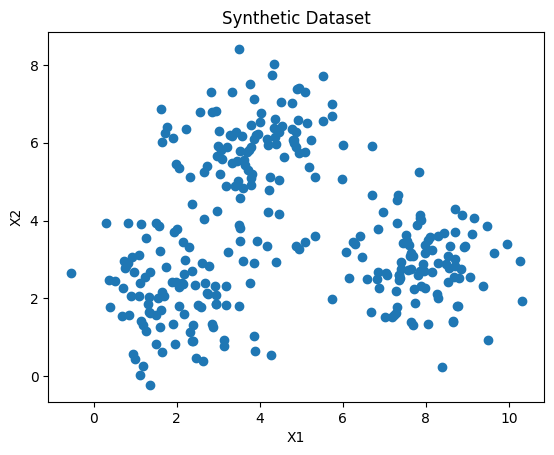

In [4]:
plt.scatter(X[:,0],X[:,1])
plt.title("Synthetic Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
class KMeans():
    def __init__(self, x, **kwargs):
        self.k = kwargs.get('k', 2)
        self.x = x
        self.n, self.m = self.x.shape
        self.centroids = self.init_centroids()
        self.clusters = np.zeros(self.n)
        self.inertia = None
        self.silhouette_score = None


    def init_centroids(self):
        """randomly pick first centroids, chooses within range of data dimensions
        params:
            none
        returns:
            self.centroids. k randomly chosen centroids"""
        
        # initialize an empty array for the centroids
        self.centroids = np.array([np.zeros(self.m) for k_ in range(self.k)])

        # loop through dataset, getting random value within range of each dimension
        for k_ in range(self.k):
            for i in range(self.m):
                low = self.x[:,i].min()
                high = self.x[:,i].max()
                self.centroids[k_] = np.random.uniform(low = low, high = high, size = (2,))
        return self.centroids


    def update_centroids(self):
        """find the mean of each cluster of data points and update centroid to be this value"""
        
        for i in range(self.k):
            self.centroids[i] = np.mean(self.x[self.clusters == i], axis = 0)


    def cluster(self):
        """assigns datapoints to nearest cluster, updates centroids until convergence
        converged = previous centroids are close enough to updated centroids"""

        converged = False
        while not converged:
            prev = self.centroids.copy()
            for i, x in enumerate(self.x):
                self.clusters[i] = np.argmin(np.sqrt(np.sum((self.centroids - x)**2, axis = 1)))

            self.update_centroids()
            converged = np.allclose(self.centroids, prev, rtol = 1e-1, atol = 1e-1)


    def calc_inertia(self):
        """calculate inertia"""
        
        self.inertia = 0
        for i in range(self.k):
            self.inertia += np.sum(self.x[self.clusters == i] - self.centroids[i])**2
        
        return self.inertia


    def calc_silhouette(self):
        """calculate silhouette score
        s = (b-a)/max(a,b)"""
        
        dist = lambda xi,c: np.mean(np.sqrt(np.sum((self.x[self.clusters == c] - xi)**2, axis=1)))
        
        silhouettes = []

        for i in range(len(self.x)):
            # Calculate a
            a = dist(self.x[i], self.clusters[i])

            # Calculate b
            b = np.min([dist(self.x[i], c) for c in range(self.k) if c != self.clusters[i] ])

            silhouettes.append((b - a) / max(a, b))

        self.silhouette_score = np.mean(silhouettes)

        return self.silhouette_score


We'll set $k=2$ and see how the clustering performs.

In [6]:
kmeans = KMeans(X, k = 2)

In [7]:
kmeans.cluster()

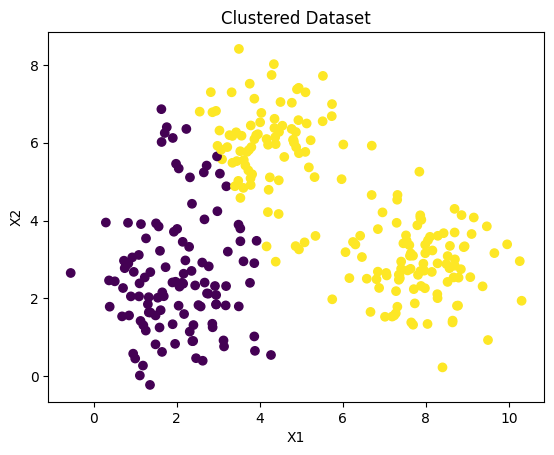

In [8]:
plt.scatter(X[:,0], X[:,1], c = kmeans.clusters)
plt.title("Clustered Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [9]:
kmeans.calc_inertia()

9.24817137931327e-25

In [10]:
kmeans.calc_silhouette()

0.4259387006417295

The inertia is very low, basically 0, and the silhouette score shows it is negative but close to zero, which isn't necessarily great.

Below we'll test out several other values for $k$ and see if we can determine the optimal value using these measures.

In [11]:
inertias = []
s_scores = []
K = 6
for k_ in range(2,K):
    print(f"k = {k_}")
    kmeans = KMeans(X, k = k_)
    kmeans.cluster()
    inertias.append(kmeans.calc_inertia())
    s_scores.append(kmeans.calc_silhouette())

k = 2
k = 3
k = 4
k = 5


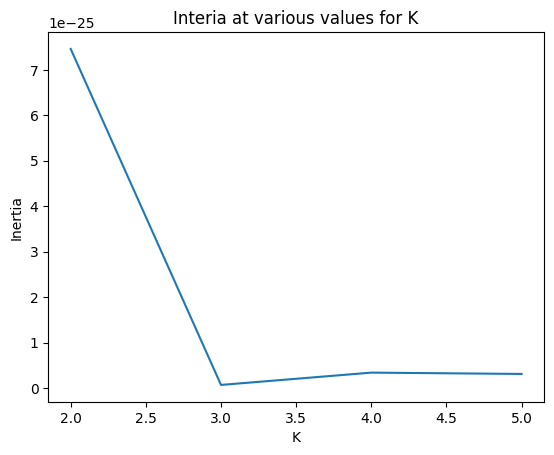

In [12]:
plt.plot(list(range(2,K)), inertias)
plt.title("Interia at various values for K")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

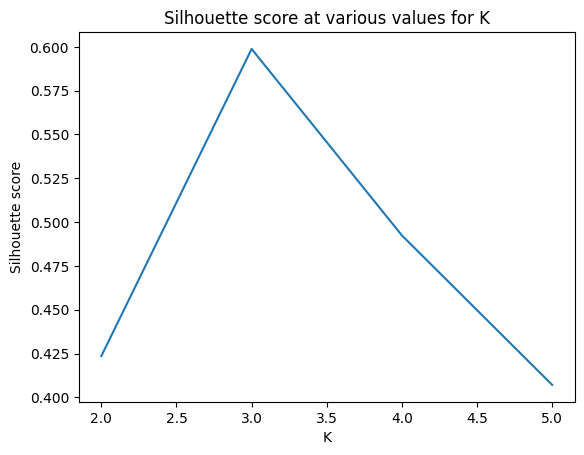

In [13]:
plt.plot(list(range(2,K)), s_scores)
plt.title("Silhouette score at various values for K")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

## Summary

We can see from these plots that when $k=3$ the inertia shows a sharp elbow and silhouette score is highest. At the highest value of $k$, here it was just $k=5$ these values are the lowest. The trick is to find the optimal $k$ value. Looking at the elbow plot we can see after $k=3$ the change in inertia is minimal, and that elbow is probably the value we should choose. This makes sense as we set the dataset to have 3 classes. We could choose a higher $k$, and this isn't necessarily wrong, it just depends on the goal of the learning project. The silhouette score is also highest at $k=3$, showing a clear point to select $k$. Both of these tools can be helpful for identifying $k$, but they will not always be perfect.